In [39]:
import pandas as pd
from IPython.display import display
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "dashboard"))
import utils

# --- Load data ---
meta_kv = utils.load_meta()
ohlcv = utils.load_ohlcv()
indicators = utils.load_indicators()

ticker = "AAPL"  # Change as needed

# --- 1. Build robust meta panel ---
# Pivot meta_kv to wide format
meta_wide = meta_kv.pivot(index="ticker", columns="key", values="value").reset_index()

# Use final display names for columns
meta_fields_orig = ["longName", "sector", "country", "currency", "latest_price"]
meta_fields_disp = ["name", "sector", "country", "currency", "price"]

meta_row = meta_wide[meta_wide["ticker"] == ticker]

meta_dict = {}
for orig, disp in zip(meta_fields_orig, meta_fields_disp):
    if orig == "latest_price":
        price = utils.get_latest_price(ohlcv, ticker)
        # Round if it's a number, else just pass through (for "not available")
        if isinstance(price, (float, int)) and pd.notna(price):
            meta_dict[disp] = round(price, 2)
        else:
            meta_dict[disp] = price
    elif orig in meta_row.columns:
        val = meta_row[orig].values[0]
        meta_dict[disp] = val if pd.notna(val) else "not available"
    else:
        meta_dict[disp] = "not available"

meta_df = pd.DataFrame([meta_dict], columns=meta_fields_disp)
display(meta_df.style.hide(axis="index"))

# --- 2. Latest indicators panel ---
ind_fields = ["sma20", "sma50", "rsi14", "vol20", "vol60"]
ind = indicators[indicators["ticker"] == ticker].sort_values("date").tail(1)
ind_dict = {field: (ind[field].values[0] if field in ind and pd.notna(ind[field].values[0]) else "not available") for field in ind_fields}
ind_df = pd.DataFrame([ind_dict], columns=ind_fields)
display(ind_df.style.hide(axis="index"))

name,sector,country,currency,price
Apple Inc.,Technology,United States,USD,226.010000


sma20,sma50,rsi14,vol20,vol60
219.142500,211.216000,68.947769,0.307178,0.221672


C:\Users\sherv\AppData\Local\Temp\ipykernel_32336\1991691584.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


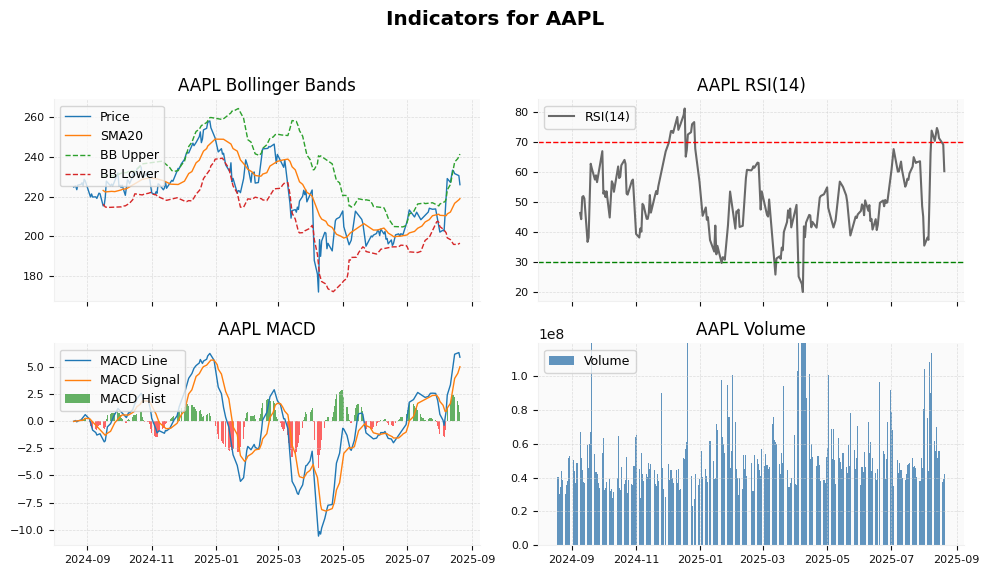

In [40]:
# Load data (however you normally do; usually with utils.load_ohlcv)
ohlcv = utils.load_ohlcv()
ticker = "AAPL"

fig, axs = utils.plot_indicators_improved(ohlcv, ticker, lookback=252)
fig.show()

C:\Users\sherv\workingdir\Projects\stock_analysis_tool\git\dashboard\utils.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\sherv\workingdir\Projects\stock_analysis_tool\git\dashboard\utils.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\sherv\AppData\Local\Temp\ipykernel_32336\362006562.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


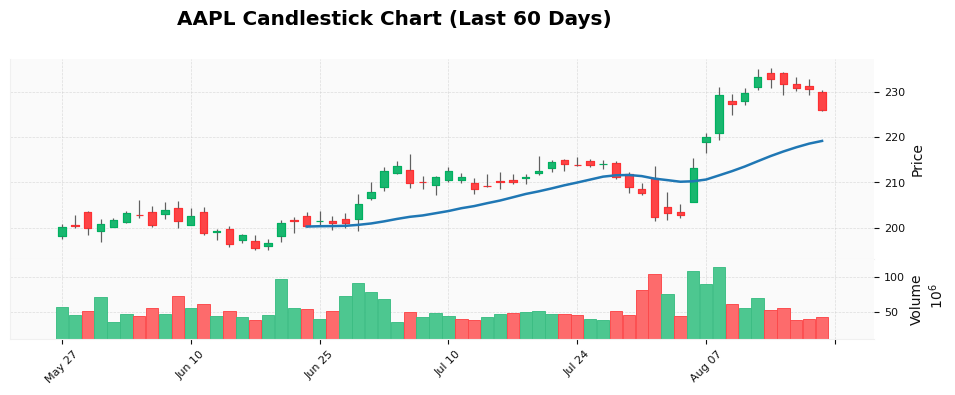

In [41]:
ohlcv = utils.load_ohlcv()
ticker = "AAPL"

fig, axes = utils.plot_candlestick(ohlcv, ticker, lookback=60)
fig.show()


C:\Users\sherv\AppData\Local\Temp\ipykernel_32336\1563818502.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
C:\Users\sherv\AppData\Local\Temp\ipykernel_32336\1563818502.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


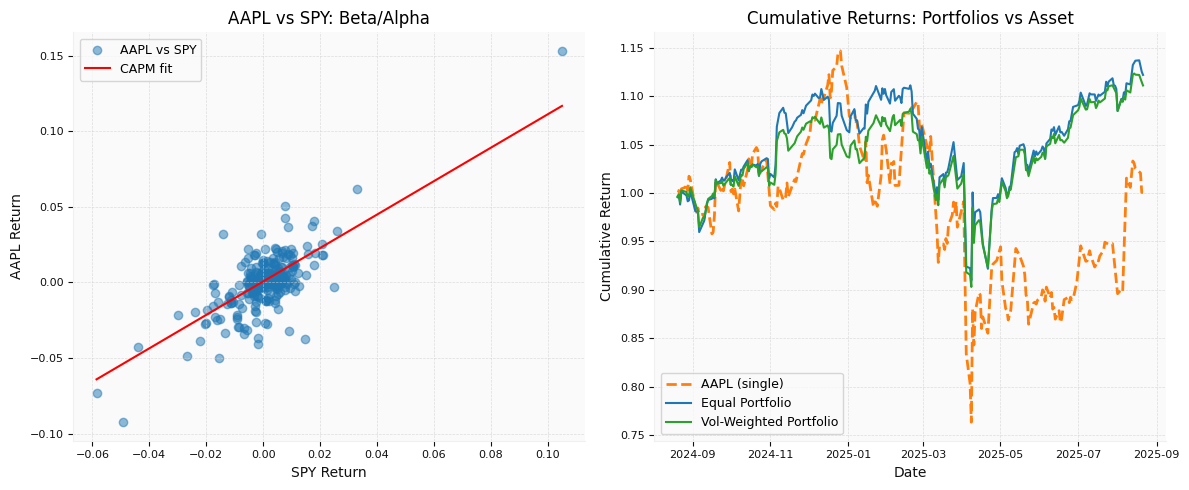

In [42]:
# Load ohlcv data (or however your data loads)
ohlcv = utils.load_ohlcv()

# Compute returns (assuming daily close-to-close returns)
returns = (
    ohlcv.sort_values("date")
    .pivot(index="date", columns="ticker", values="close")
    .pct_change()
    .dropna(how="all")
)

# Now your previous code will work
capm_df = utils.compute_capm_betas(returns, market_col="SPY")
fig, axs = utils.plot_portfolio_returns_panel(returns, capm_df, asset="AAPL", market_col="SPY")
fig.show()


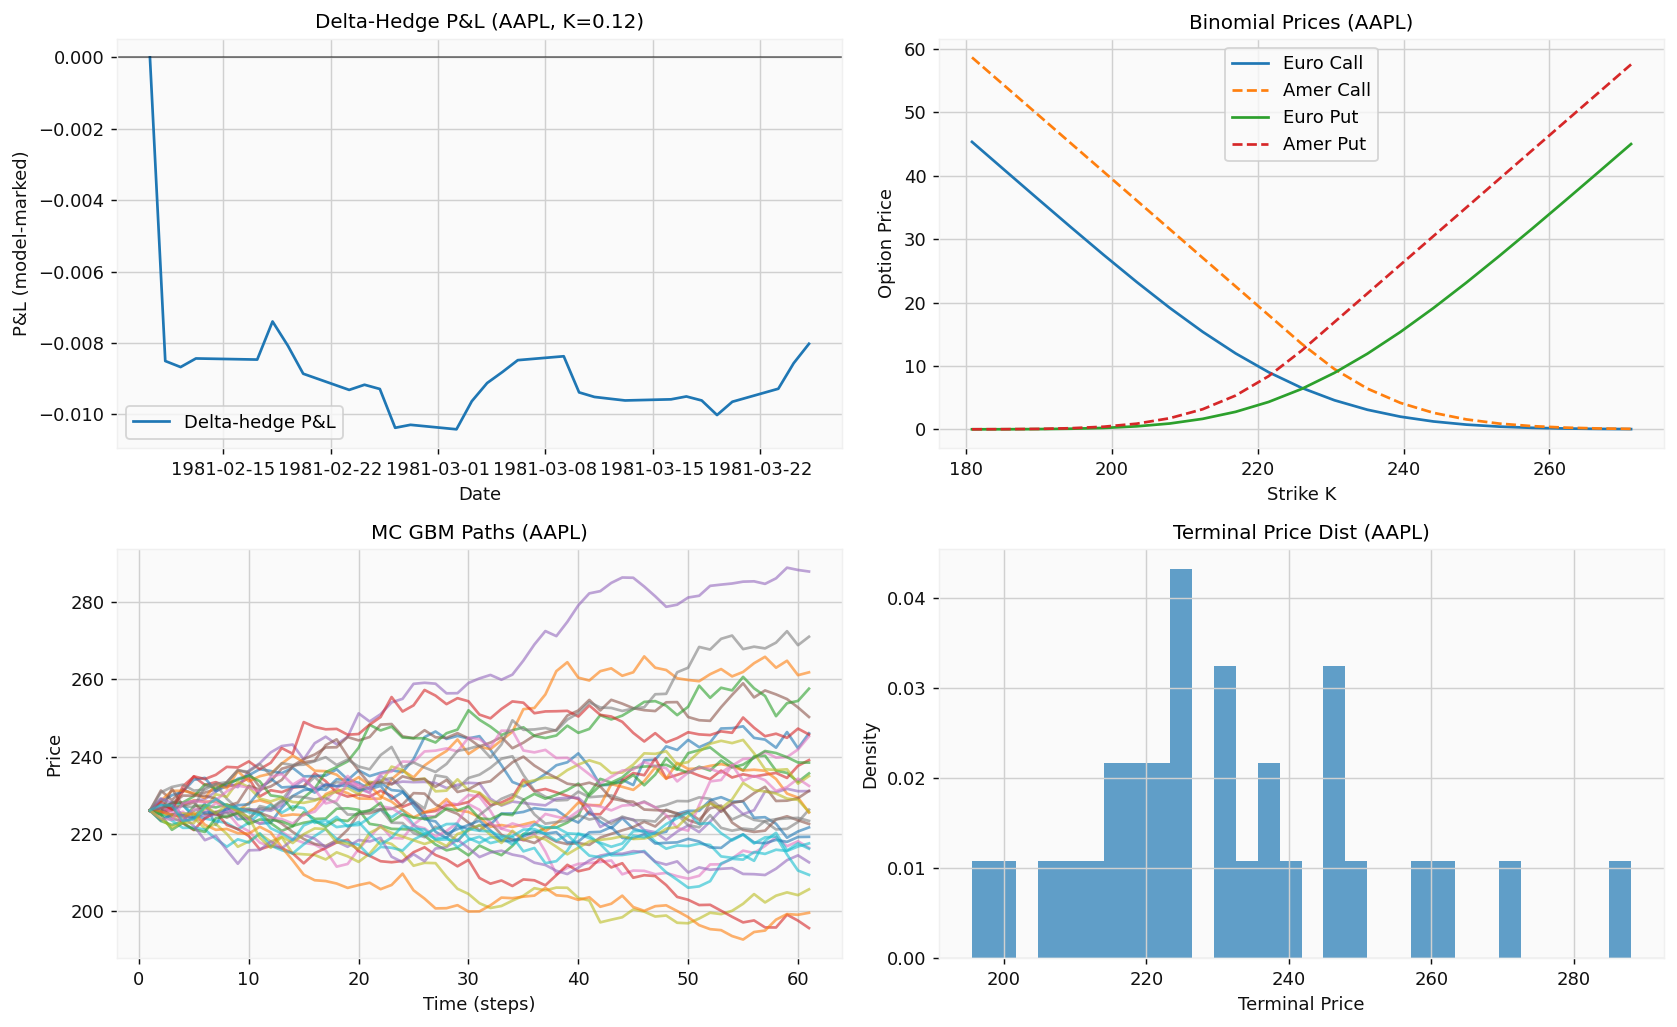

In [43]:
ticker = "AAPL"  # or any ticker

# Load data
delta_hedge = utils.load_delta_hedge()
binomial = utils.load_binomial_prices()
mc_gbm = utils.load_mc_gbm_paths()

# 2x2 grid for: delta-hedge pnl, binomial, MC paths, MC terminal histogram
fig, axs = plt.subplots(2, 2, figsize=(13, 8), dpi=130)
fig.subplots_adjust(hspace=0.3, wspace=0.25)

# Delta hedge P&L
ax = axs[0,0]
df = delta_hedge[delta_hedge["ticker"] == ticker]
if not df.empty:
    ax.plot(df["date"], df["hedge_pnl"], label="Delta-hedge P&L")
    ax.axhline(0, lw=1, color="k", alpha=0.5)
    strike = df["strike"].iloc[0] if "strike" in df.columns else float("nan")
    ax.set_title(f"Delta-Hedge P&L ({ticker}, K={strike:.2f})", fontsize=11)
    ax.set_xlabel("Date")
    ax.set_ylabel("P&L (model-marked)")
    ax.legend()
else:
    ax.text(0.5, 0.5, "No P&L data", ha="center", va="center")
    ax.set_title("Delta-Hedge P&L", fontsize=11)

# Binomial Prices vs Strike
ax = axs[0,1]
dfb = binomial[binomial["ticker"] == ticker]
if not dfb.empty:
    ax.plot(dfb["K"], dfb["Euro_Call"], label="Euro Call")
    ax.plot(dfb["K"], dfb["Amer_Call"], label="Amer Call", linestyle="--")
    ax.plot(dfb["K"], dfb["Euro_Put"],  label="Euro Put")
    ax.plot(dfb["K"], dfb["Amer_Put"],  label="Amer Put", linestyle="--")
    ax.set_title(f"Binomial Prices ({ticker})", fontsize=11)
    ax.set_xlabel("Strike K")
    ax.set_ylabel("Option Price")
    ax.legend()
else:
    ax.text(0.5, 0.5, "No binomial price data", ha="center", va="center")
    ax.set_title("Binomial Prices", fontsize=11)

# MC GBM Paths
ax = axs[1,0]
gbm = mc_gbm[mc_gbm["ticker"] == ticker]
if not gbm.empty:
    time_cols = [c for c in gbm.columns if c.startswith('t')]
    t_grid = range(len(time_cols))
    paths = gbm[time_cols].apply(pd.to_numeric, errors="coerce").ffill(axis=1).values[:30]
    for i in range(paths.shape[0]):
        ax.plot(t_grid, paths[i], alpha=0.6)
    ax.set_title(f"MC GBM Paths ({ticker})", fontsize=11)
    ax.set_xlabel("Time (steps)")
    ax.set_ylabel("Price")
else:
    ax.text(0.5, 0.5, "No MC paths", ha="center", va="center")
    ax.set_title("MC GBM Paths", fontsize=11)

# MC GBM Terminal Histogram
ax = axs[1,1]
if not gbm.empty and paths.shape[0] > 0:
    terminal_vals = paths[:, -1]
    ax.hist(terminal_vals, bins=30, density=True, alpha=0.7)
    ax.set_title(f"Terminal Price Dist ({ticker})", fontsize=11)
    ax.set_xlabel("Terminal Price")
    ax.set_ylabel("Density")
else:
    ax.text(0.5, 0.5, "No terminal data", ha="center", va="center")
    ax.set_title("Terminal Price Dist", fontsize=11)

plt.tight_layout()
plt.show()
